# Cleaning the newspaper archive

In [1]:
import os
import re
import json
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from functools import partial
from itertools import product
from collections import Counter
from unicodedata import category
from multiprocessing import cpu_count
from utils import multicore_apply

import fasttext
from umap import UMAP
from scipy.linalg import norm
from reo_toolkit import is_maori
from gensim.models import Phrases
from nltk.tokenize import word_tokenize, sent_tokenize

import warnings
from numba.errors import NumbaWarning
warnings.filterwarnings("ignore", category = UserWarning)
warnings.simplefilter("ignore", category = NumbaWarning)

In [2]:
def remove_punctuation(text):
    return ''.join(ch for ch in text if category(ch)[0] != 'P')
    
def normalize_text(text):
    text = re.sub("\s{2,}", " ", text)
    return remove_punctuation(text.lower())

## Cleaning the text

In [3]:
with open('../data/maori_newspapers.json', 'r') as f:
    papers = pd.DataFrame(json.load(f))

In [4]:
col_patterns = {
    'newspaper_id': '([A-Z]+)[^/]+$',
    'year': '[A-Z]+([0-9]{4})[^/]+$',
    'month': '[A-Z]+[0-9]{4}([0-9]{2})[^/]+$',
    'day': '[A-Z]+[0-9]{6}([0-9]{2})[^/]+$',
    'id': '[A-Z]+[0-9]+\.([^/]+)$'
}

for col, pattern in col_patterns.items():
    papers[col] = papers.url.str.extract(pattern)

papers.head()

,url,text,newspaper_id,year,month,day,id
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11
2,https://paperspast.natlib.govt.nz/newspapers/A...,KI WGA MAORI : '• ■ ‘ ■ ■ - ■ ■ ; 1 SVgil c.la...,AONUPEP,1892,06,04,2.14.1
3,https://paperspast.natlib.govt.nz/newspapers/A...,HE MEA TUKU MAI E NGA WHARE ERUA O TE PAREMATA...,AONUPEP,1892,06,04,2.13
4,https://paperspast.natlib.govt.nz/newspapers/A...,KO TE NIUPEPA MAORI. EI te Turei tuatahi o te ...,AMW,1848,10,19,2.14.1


In [5]:
papers['paragraph'] = papers.text.apply(lambda s: s.split("\n"))
papers = papers.explode('paragraph')

In [6]:
%%time
papers['sentence'] = multicore_apply(papers.paragraph, sent_tokenize)
papers = papers.explode('sentence')
papers = papers[~papers.sentence.isna()]

papers.head()

100%|██████████| 94.3k/94.3k [00:00<00:00, 244kit/s]  
94346it [00:00, 512100.34it/s]


CPU times: user 22.1 s, sys: 3.33 s, total: 25.5 s
Wall time: 23 s


,url,text,newspaper_id,year,month,day,id,paragraph,sentence
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","WANTKD, a smart LAD, ' and n rite."
0,https://paperspast.natlib.govt.nz/newspapers/A...,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...",AMW,1848,07,18,2.12.1,"WANTKD, a smart LAD, ' and n rite. Apply ai Zi...","Apply ai Zi alamli'i"" Office."
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.,KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","""Na te Tika i toa ai."""
1,https://paperspast.natlib.govt.nz/newspapers/A...,"KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.\n""Na te...",AMW,1848,07,18,2.11,"""Na te Tika i toa ai."" Turei, Huri 17, 1848.","Turei, Huri 17, 1848."


In [7]:
# Print the number of sentences in te_ara
print("There are {} sentences in the māori newspaper archive".format(len(papers)))

There are 805342 sentences in the māori newspaper archive


Here are the first 5 sentences:

In [8]:
print('\n'.join(papers.sentence[:5]))

WANTKD, a smart LAD, ' and n rite.
Apply ai Zi alamli'i" Office.
KO TE KAI-WHAKAMATAARA O NGA IWI ERUA.
"Na te Tika i toa ai."
Turei, Huri 17, 1848.


## Text cleaning

In [9]:
def extract_words(text):
    text = text.lower()
    results = []
    for word in word_tokenize(text):
        if re.search('[a-zāēīōū]', word):
            result = re.sub('\s{2,}', ' ',
                re.sub('[^a-zāēīōū]', ' ', word)
            )
            for res in result.split():
                results.append(res)
    return results

In [10]:
%%time
papers['words'] = multicore_apply(papers['sentence'], extract_words)

100%|██████████| 805k/805k [00:03<00:00, 254kit/s]     
805342it [00:01, 535689.86it/s]


CPU times: user 2min 57s, sys: 22.2 s, total: 3min 19s
Wall time: 3min


In [11]:
word_counts = papers['words'].explode().value_counts()
word_counts = word_counts.to_frame().reset_index()
word_counts.columns = ['word', 'count']
word_counts.to_csv('../data/papers_word_counts.csv', index = False)
word_counts

,word,count
0,te,763785
1,i,643241
2,e,388836
3,nga,356423
4,o,355744
...,...,...
441061,apnrinraliau,1
441062,unift,1
441063,hohoutia,1
441064,jkootaffimanke,1


In [14]:
def drop_macrons(text):
    macron_dict = {
        'ā': 'a',
        'ē': 'e',
        'ī': 'i',
        'ō': 'o',
        'ū': 'u',
        'Ā': 'A',
        'Ē': 'E',
        'Ī': 'I',
        'Ō': 'O',
        'Ū': 'U',
    }
    
    for k, v in macron_dict.items():
        text = text.replace(k, v)
    
    return text

In [15]:
te_ara_word_counts = pd.read_csv("../data/te_ara_word_counts.csv")

te_ara_word_counts = te_ara_word_counts[~te_ara_word_counts.word.isna()]
# te_ara_word_counts['word'] = te_ara_word_counts.word.apply(drop_macrons)
te_ara_word_counts = (te_ara_word_counts
    .groupby('word')
    .sum('count')
    .reset_index()
    .sort_values('count', ascending = False)
    .reset_index(drop = True)
)

te_ara_word_counts

,word,count
0,te,189061
1,i,116950
2,o,70319
3,ngā,56889
4,ki,56730
...,...,...
26292,pohara,1
26293,poharama,1
26294,poharatia,1
26295,poharu,1


In [16]:
papers_word_counts = word_counts
papers_word_counts.columns = ['word', 'papers_count']
te_ara_word_counts.columns = ['word', 'te_ara_count']

In [17]:
word_counts = papers_word_counts.merge(te_ara_word_counts, how = 'left', on = ['word']).fillna(0)
word_counts

,word,papers_count,te_ara_count
0,te,763785,189061.0
1,i,643241,116950.0
2,e,388836,32319.0
3,nga,356423,273.0
4,o,355744,70319.0
...,...,...,...
441061,apnrinraliau,1,0.0
441062,unift,1,0.0
441063,hohoutia,1,3.0
441064,jkootaffimanke,1,0.0


In [18]:
word_counts[word_counts.te_ara_count == 1]

,word,papers_count,te_ara_count
153,ratau,12878,1.0
196,penei,9991,1.0
242,nupepa,7650,1.0
256,panui,6988,1.0
276,kaati,6265,1.0
...,...,...,...
438420,waiewe,1,1.0
438918,borabora,1,1.0
439064,ararua,1,1.0
440111,marker,1,1.0


In [19]:
word_counts[word_counts.te_ara_count == 0]

,word,papers_count,te_ara_count
78,ote,26338,0.0
105,tc,19631,0.0
141,lie,13875,0.0
236,otira,8143,0.0
258,tons,6955,0.0
...,...,...,...
441060,pukewhero,1,0.0
441061,apnrinraliau,1,0.0
441062,unift,1,0.0
441064,jkootaffimanke,1,0.0


## Phrase modelling

We can use gensim to join common phrases in the text.

In [20]:
def phrase_model(lines, min_count, threshold, phrase_length):
    
    for _ in range(phrase_length):
        sentence_stream = [doc.split(" ") for doc in lines]
        bigram = Phrases(sentence_stream, min_count=min_count, threshold=threshold)
        lines = [' '.join(bigram[line.split()]) for line in lines]
        
    return lines

In [21]:
maori_words  = set(word for word in papers_word_counts.word if is_maori(word))
te_ara_words = set(word for word in te_ara_word_counts.word if is_maori(word))

In [22]:
%%time
papers['phrase'] = phrase_model(
    (papers.words
        .apply(lambda x: ' '.join(
            [y for y in x if y in te_ara_words or y in maori_words]
        ))),
    min_count = 30,
    threshold = 10,
    phrase_length = 5
)

CPU times: user 5min 1s, sys: 0 ns, total: 5min 1s
Wall time: 5min 1s


In [23]:
%%time
phrase_counts = papers.phrase.apply(str.split).explode().value_counts().to_frame().reset_index()
phrase_counts.columns = ['word', 'count']
phrase_counts

CPU times: user 7.41 s, sys: 0 ns, total: 7.41 s
Wall time: 7.4 s


,word,count
0,te,763785
1,e,388836
2,nga,356423
3,o,355744
4,ki,259854
...,...,...
124091,porohipihana,1
124092,tiaoho,1
124093,oaikahatanga,1
124094,hamikapu,1


In [25]:
phrase_counts[phrase_counts.word.str.contains("_")]

,word,count
256,niu_tireni,3423
292,muri_iho,2940
508,hau_hau,1395
513,nui_tireni,1368
525,hoa_riri,1332
...,...,...
99340,taa_timi,1
107499,kakau_kaheru_kakaurakaraka_waea,1
109147,whanau_kotoa,1
119524,mihini_kowha_kanga_whakatotokanga,1


## Train fasttext model

In [26]:
corpus_file = '../data/papers_corpus.txt'

In [37]:
with open(corpus_file, 'w') as f:
    for line in papers.loc[papers.phrase.str.len() != 0, 'phrase']:
        f.write(line)

In [38]:
%%time
model = fasttext.train_unsupervised(corpus_file, minCount = 30)

CPU times: user 8min 39s, sys: 0 ns, total: 8min 39s
Wall time: 37.2 s


In [39]:
model_data = pd.DataFrame({'word': model.words})
model_data['word_vector'] = model_data.word.apply(model.get_word_vector)
model_data

,word,word_vector
0,te,"[0.06597284, 0.2705766, -0.045844827, 0.103687..."
1,nga,"[0.030615143, 0.2837411, -0.053941015, 0.00753..."
2,e,"[0.014493675, 0.23672661, -0.045737352, 0.1289..."
3,o,"[0.035564825, 0.19074082, -0.025912128, 0.0986..."
4,ki,"[0.13471192, 0.24540189, 0.03082043, 0.1196639..."
...,...,...
7977,maoriu,"[-0.0676022, -0.14062425, -0.2964567, 0.181153..."
7978,noma,"[0.08416159, 0.18557152, -0.19653594, 0.030444..."
7979,naonao,"[-0.26986372, 0.17815332, -0.6280442, -0.66005..."
7980,utuheoi,"[-0.47227243, -0.109857395, 0.3773578, 0.14011..."


In [40]:
model_data[model_data.word.str.contains("_")]

,word,word_vector
283,niu_tireni,"[0.046355765, 0.24385586, 0.28202933, 0.132315..."
362,muri_iho,"[0.09197398, 0.15408096, -0.4754358, 0.4562597..."
511,hoa_riri,"[0.109761916, -0.059389953, -0.026795546, -0.4..."
523,hau_hau,"[-0.08364646, -0.32143947, -0.21073739, 0.0617..."
609,nui_tireni,"[-0.21361056, 0.16705267, 0.2623585, 0.239178,..."
...,...,...
7883,taiepa_kakau,"[-0.41907245, -0.12718819, -0.33942348, 0.5481..."
7898,mita_karaka,"[-0.115379974, -0.06300506, -0.9294519, -0.303..."
7956,taare_tikao,"[-0.32814065, 0.15894926, 0.09522301, -0.15942..."
7961,anaru_patene,"[-0.3586534, 0.24527887, -0.78124547, -0.25703..."


In [42]:
model_data['count'] = model_data.merge(word_counts, how = 'left', on = ['word'])['papers_count'].fillna(1)

In [45]:
model_data[model_data.word.str.contains("_")]

,word,word_vector,count
283,niu_tireni,"[0.046355765, 0.24385586, 0.28202933, 0.132315...",1.0
362,muri_iho,"[0.09197398, 0.15408096, -0.4754358, 0.4562597...",1.0
511,hoa_riri,"[0.109761916, -0.059389953, -0.026795546, -0.4...",1.0
523,hau_hau,"[-0.08364646, -0.32143947, -0.21073739, 0.0617...",1.0
609,nui_tireni,"[-0.21361056, 0.16705267, 0.2623585, 0.239178,...",1.0
...,...,...,...
7883,taiepa_kakau,"[-0.41907245, -0.12718819, -0.33942348, 0.5481...",1.0
7898,mita_karaka,"[-0.115379974, -0.06300506, -0.9294519, -0.303...",1.0
7956,taare_tikao,"[-0.32814065, 0.15894926, 0.09522301, -0.15942...",1.0
7961,anaru_patene,"[-0.3586534, 0.24527887, -0.78124547, -0.25703...",1.0


In [46]:
word_vectors = np.vstack(model_data.word_vector.apply(lambda x: x / norm(x)))

In [47]:
similarity_matrix = np.dot(word_vectors, word_vectors.transpose())

## Dimensionality reduction with UMAP

In [48]:
model_data

,word,word_vector,count
0,te,"[0.06597284, 0.2705766, -0.045844827, 0.103687...",763785.0
1,nga,"[0.030615143, 0.2837411, -0.053941015, 0.00753...",356423.0
2,e,"[0.014493675, 0.23672661, -0.045737352, 0.1289...",388836.0
3,o,"[0.035564825, 0.19074082, -0.025912128, 0.0986...",355744.0
4,ki,"[0.13471192, 0.24540189, 0.03082043, 0.1196639...",259854.0
...,...,...,...
7977,maoriu,"[-0.0676022, -0.14062425, -0.2964567, 0.181153...",1.0
7978,noma,"[0.08416159, 0.18557152, -0.19653594, 0.030444...",41.0
7979,naonao,"[-0.26986372, 0.17815332, -0.6280442, -0.66005...",38.0
7980,utuheoi,"[-0.47227243, -0.109857395, 0.3773578, 0.14011...",1.0


In [49]:
from sklearn.manifold import TSNE

In [50]:
# %%time
# def calculate_tsne(params, tsne_data, similarity_matrix):
#     tsne_data = tsne_data.copy()
#     perplexity, early_exaggeration = params

#     reducer = TSNE(perplexity = perplexity, early_exaggeration = early_exaggeration)
#     reduced = reducer.fit_transform(similarity_matrix)

#     tsne_data['perplexity'] = perplexity
#     tsne_data['early_exaggeration'] = early_exaggeration
    
#     tsne_data['x'] = reduced[:, 0]
#     tsne_data['y'] = reduced[:, 1]

#     tsne_data = tsne_data[['perplexity', 'early_exaggeration', 'word', 'count', 'x', 'y']]

#     tsne_data['rank'] = np.arange(len(tsne_data))

#     tsne_data = tsne_data[tsne_data.word != '</s>']

#     tsne_data.columns = ['perplexity', 'early_exaggeration', 'word', 'word_count', 'x_coord', 'y_coord', 'rank']

#     return tsne_data

# perplexitys = [2 ** (i + 1) for i in range(10)]
# early_exaggerations = [2 ** (i + 1) for i in range(8)]

# tsne_results = pd.concat(
#     multicore_apply(
#         product(perplexitys, early_exaggerations), 
#         partial(calculate_tsne, 
#                 tsne_data = model_data,
#                 similarity_matrix = similarity_matrix)),
#         n_jobs = cpu_count() - 3
# )

In [51]:
# g = (sns.FacetGrid(umap_results, col="perplexity", row="early_exaggeration", sharex = False, sharey = False)
#     .map(plt.scatter, "x_coord", "y_coord", edgecolor="w")
# )

In [54]:
%%time

def calculate_umap(params, umap_data, similarity_matrix):
    neighbors, dist = params

    reducer = UMAP(n_neighbors = neighbors, min_dist = dist)
    reduced = reducer.fit_transform(similarity_matrix)

    umap_data['n_neighbors'] = neighbors
    umap_data['min_dist'] = dist
    
    umap_data['x'] = reduced[:, 0]
    umap_data['y'] = reduced[:, 1]

    umap_data = umap_data[['n_neighbors', 'min_dist', 'word', 'count', 'x', 'y']]

    umap_data['rank'] = np.arange(len(umap_data))

    umap_data = umap_data[umap_data.word != '</s>']

    umap_data.columns = ['n_neighbors', 'min_dist', 'word', 'word_count', 'x_coord', 'y_coord', 'rank']

    return umap_data

n_neighbours = [2, 5, 10, 20, 50, 100, 200]
min_dist = [0.2, 0.4, 0.6, 0.8, 0.95, 0.99]

umap_results = pd.concat(
    multicore_apply(
        product(n_neighbours, min_dist), 
        partial(calculate_umap, 
                umap_data = model_data,
                similarity_matrix = similarity_matrix))
)

100%|██████████| 42.0/42.0 [05:52<00:00, 8.38s/it]
42it [00:00, 128490.71it/s]

CPU times: user 12.2 s, sys: 15.8 s, total: 28 s
Wall time: 5min 53s


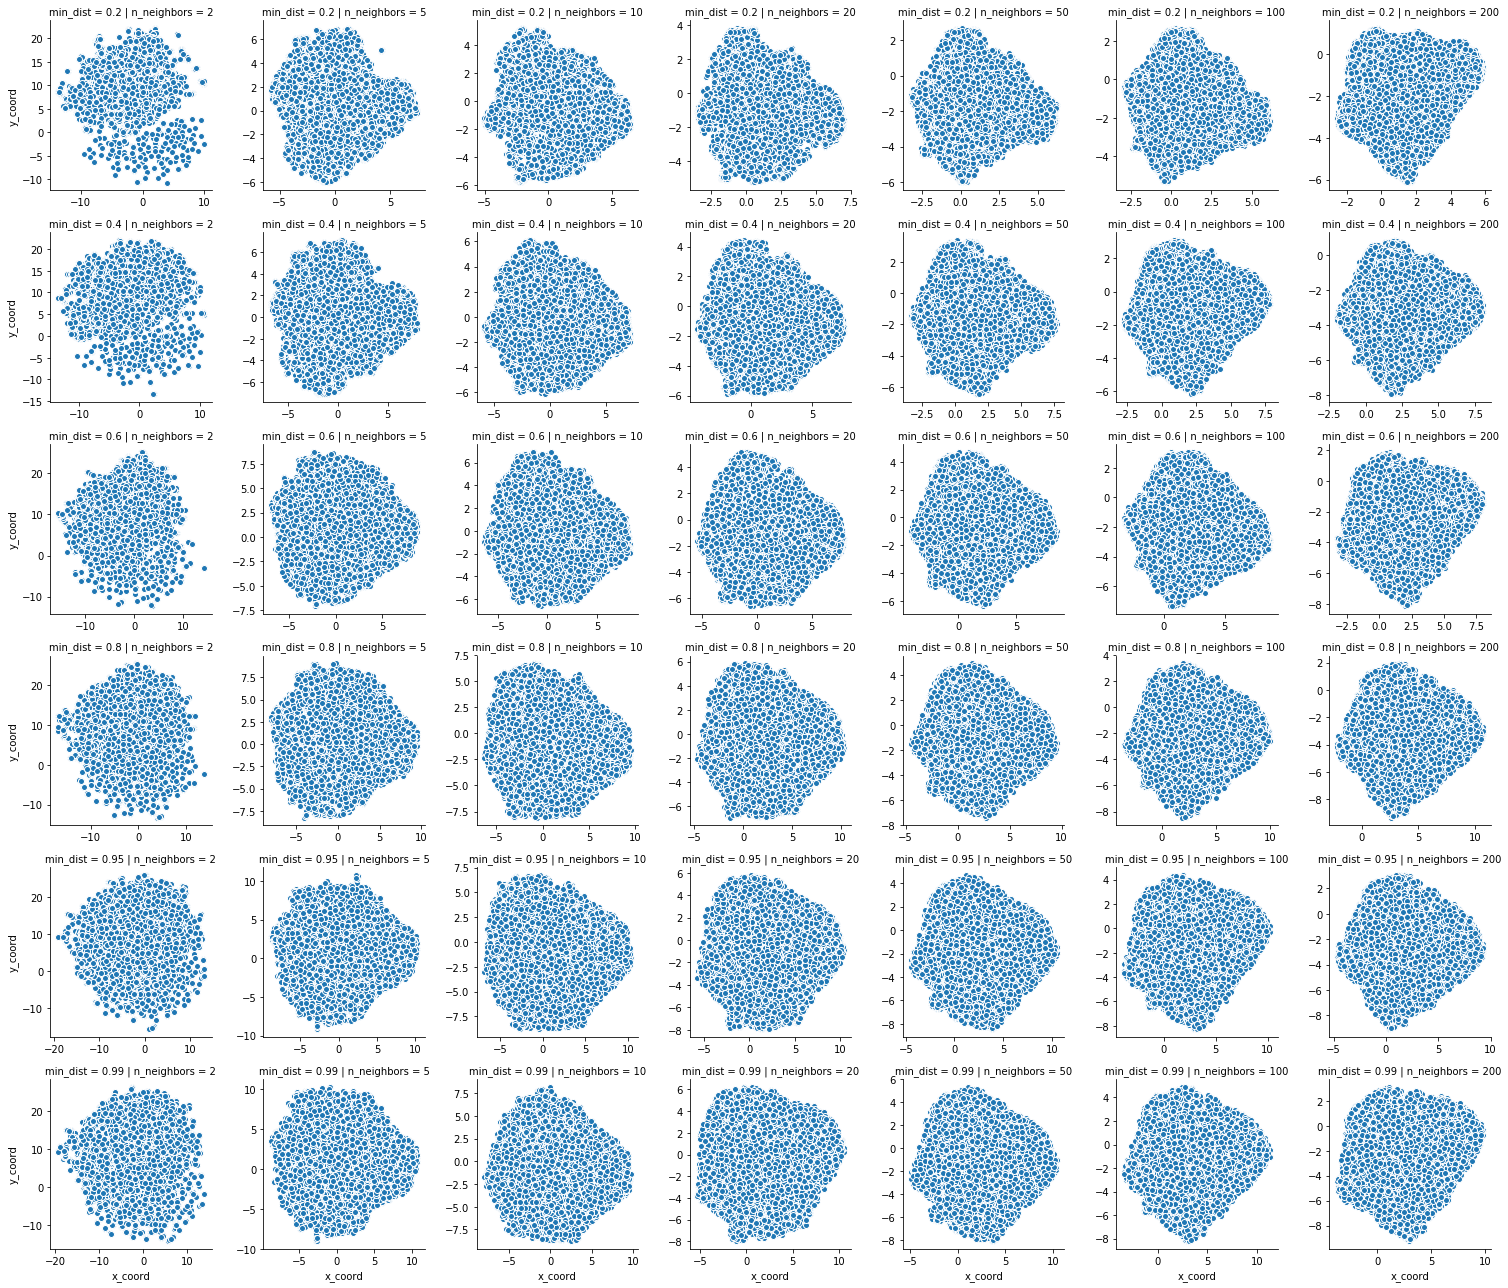

In [56]:
g = (sns.FacetGrid(umap_results, col="n_neighbors", row="min_dist", sharex = False, sharey = False)
    .map(plt.scatter, "x_coord", "y_coord", edgecolor="w")
)

In [57]:
(umap_results
     .loc[
        (umap_results.n_neighbors == 20) & \
        (umap_results.min_dist == 0.8) & \
        ((umap_results.word_count > 30) |
        (umap_results.word.str.contains("_"))),
        ['word', 'word_count', 'x_coord', 'y_coord', 'rank']
     ].reset_index(drop = True)
      .to_csv('../data/umap.csv', index = False)
)

## Saving output to disk

In [ ]:
papers.to_csv('../data/papers.csv', index = False)